In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import interpolate
from skimage import measure
import pickle
import cv2
from pathlib import Path

In [2]:
def find_contours(label_img:np.array):
    mask = ~np.all(label_img == label_img[..., :1], axis=-1) # 如果 RGB 不相等回傳 True
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    else: return contours

In [6]:
tumor_preds = dict()
result_pth = Path("/home/azetry/datasets/TACE/TACE0034_result")
for png in result_pth.glob("./*.png"):
    idx = int(png.name.replace(".png",""))
    img = cv2.imread(str(png))
    tumor_preds[idx] = find_contours(img)


with open("./data/p_slice_locations.pkl", "rb") as f:
        slice_locations = pickle.load(f)['TACE0034']


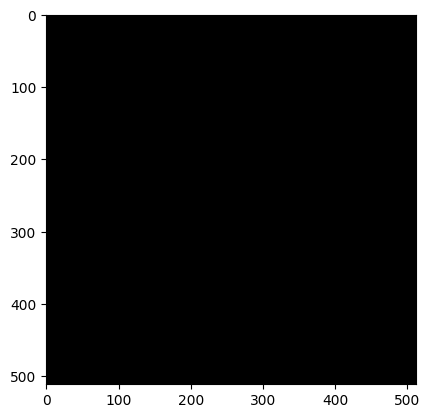

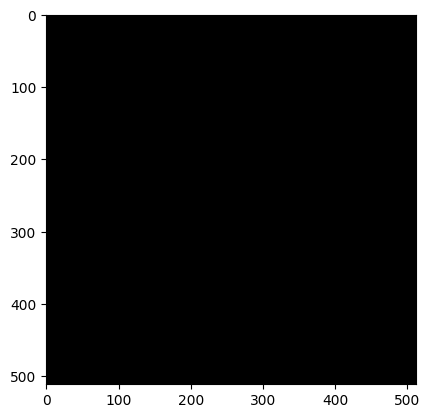

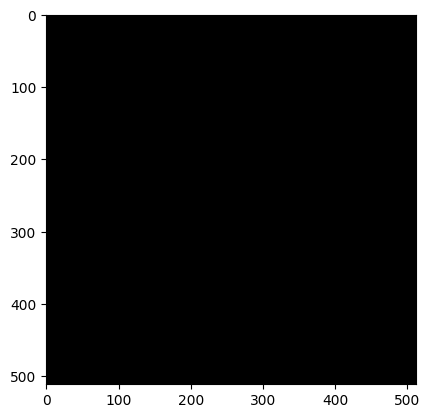

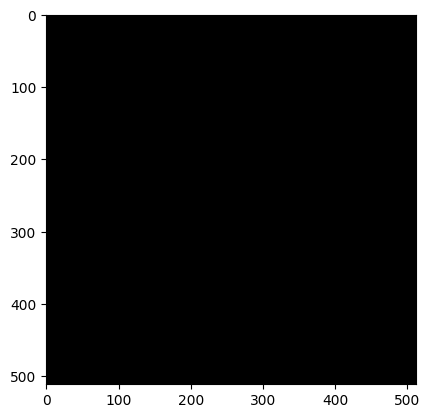

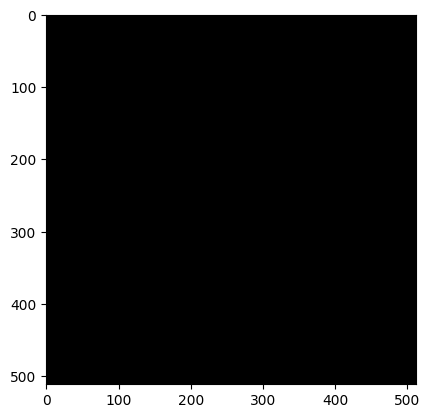

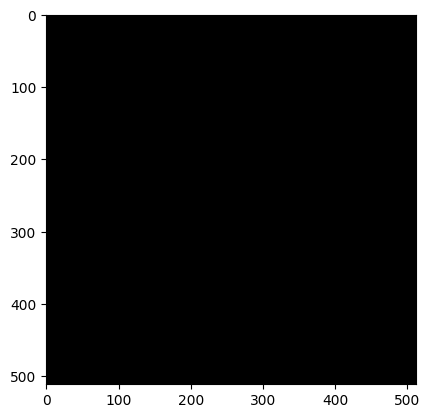

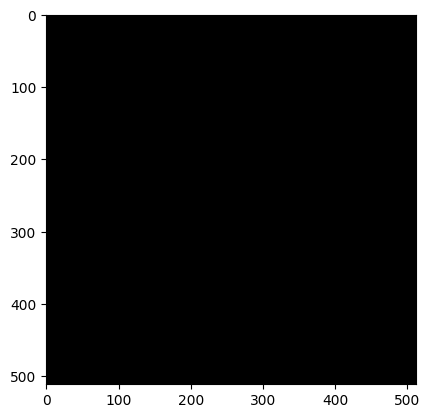

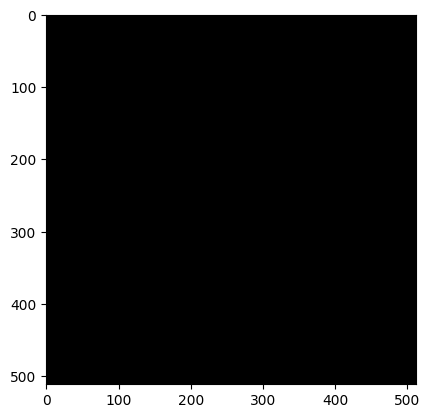

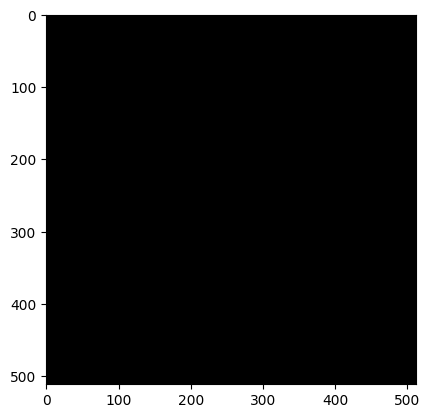

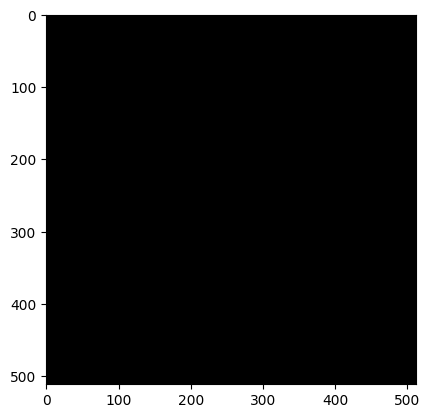

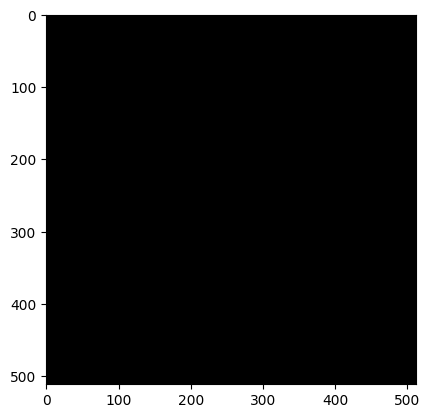

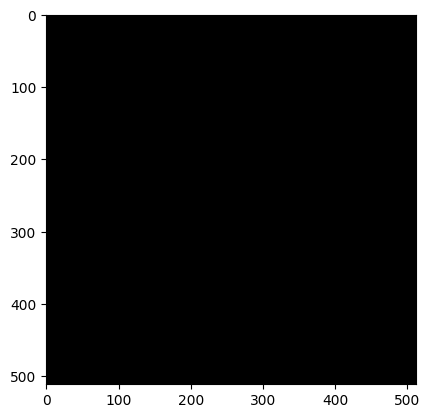

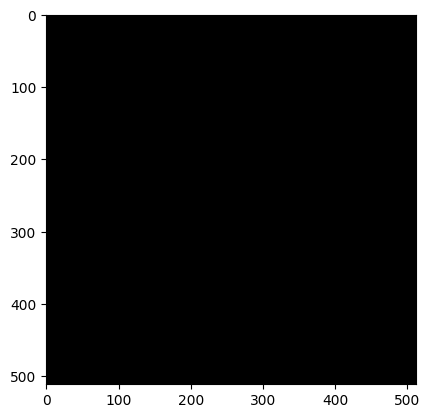

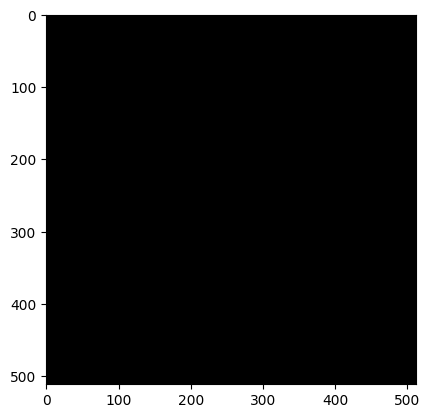

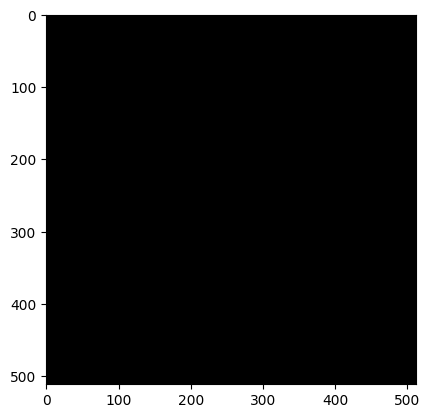

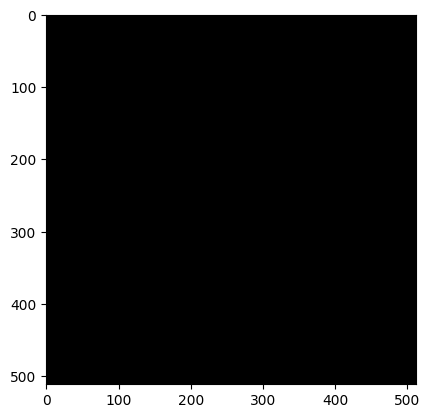

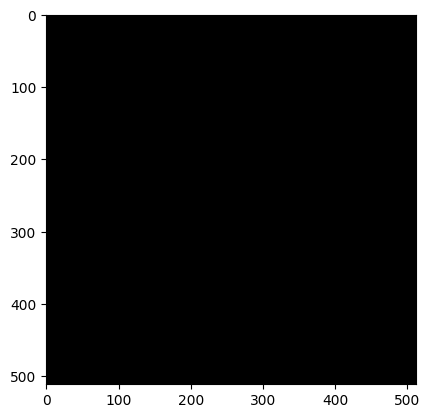

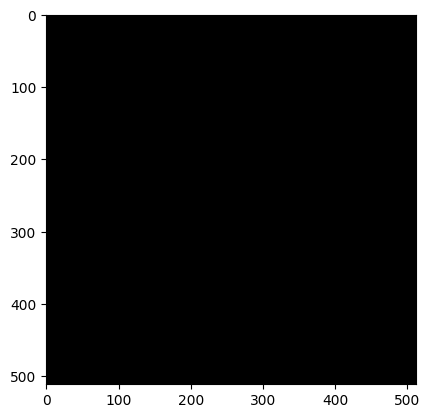

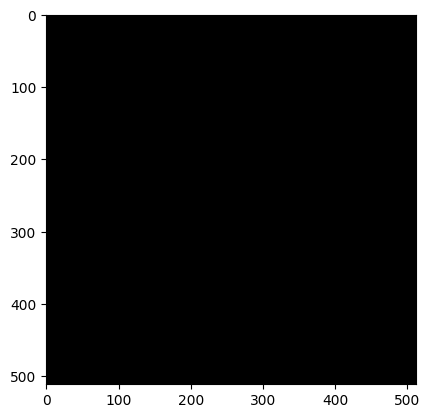

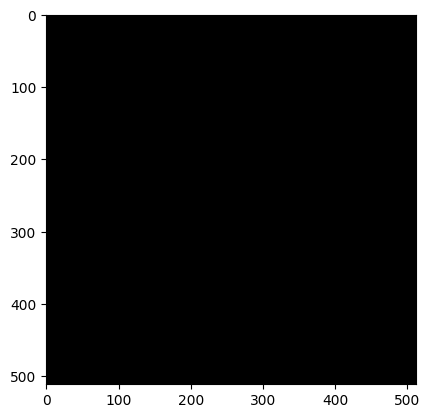

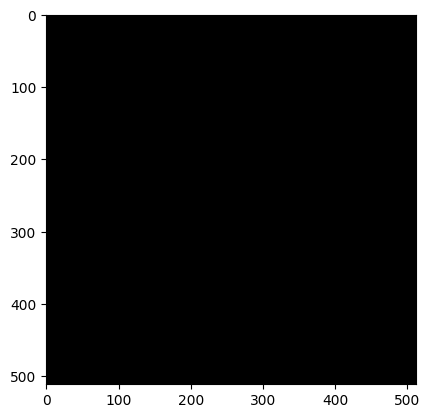

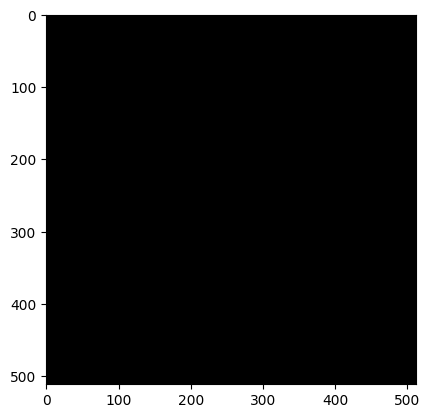

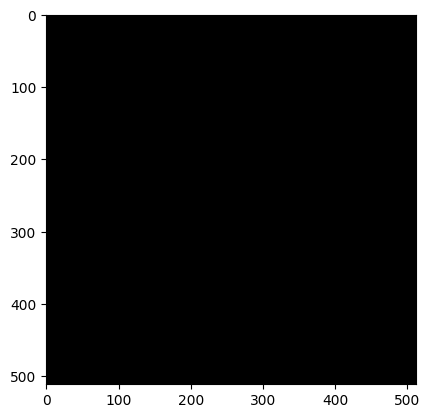

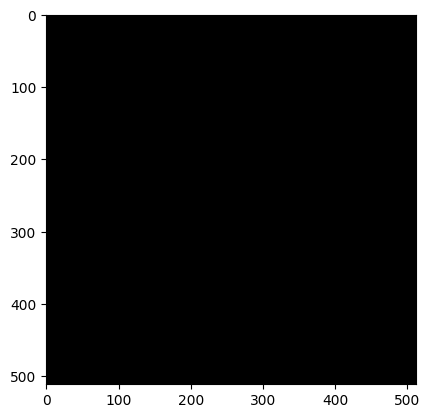

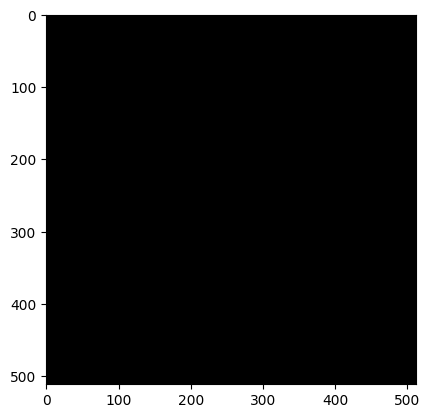

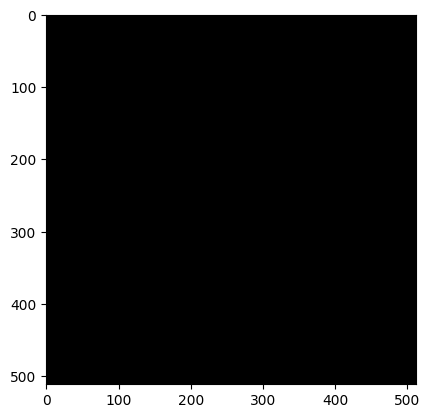

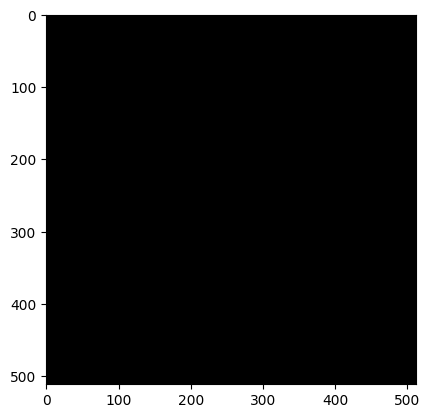

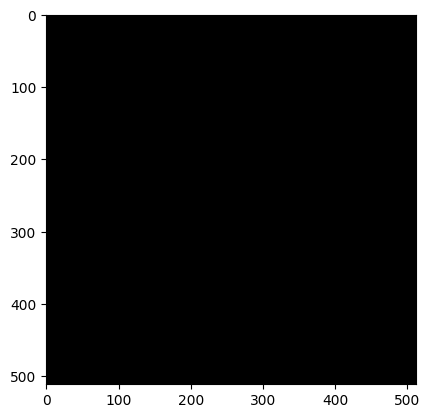

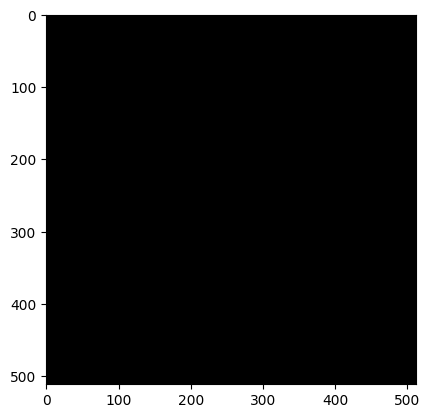

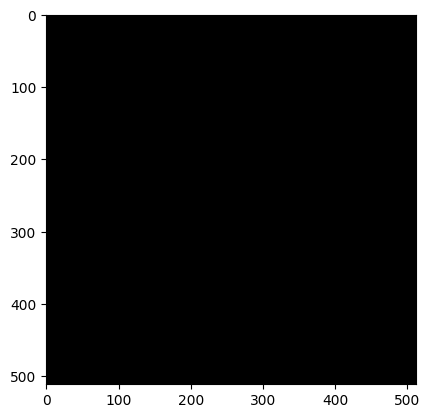

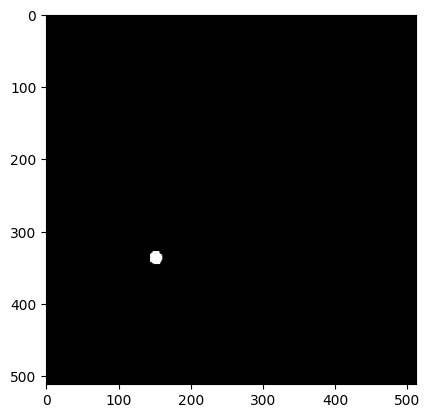

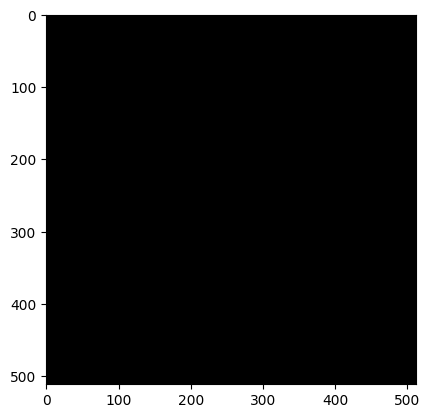

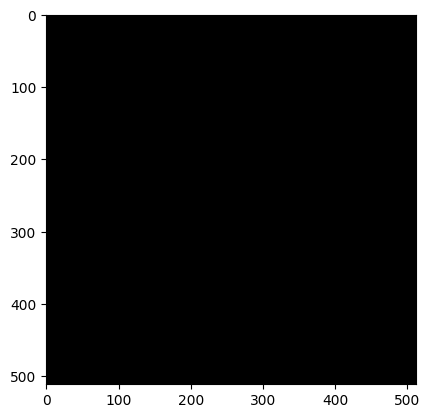

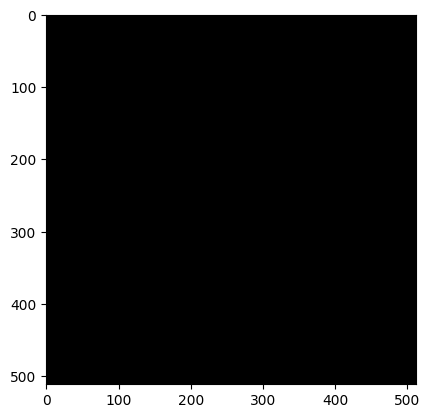

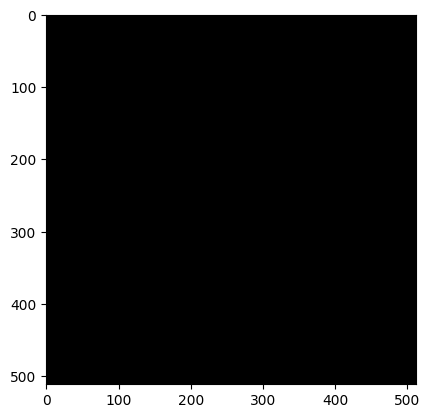

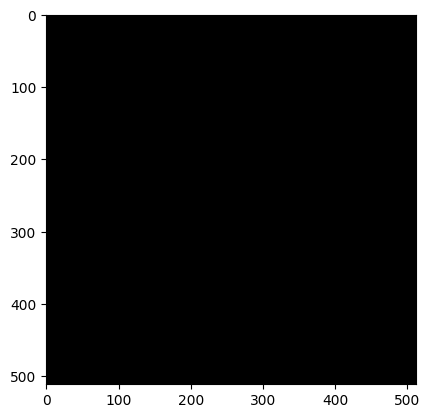

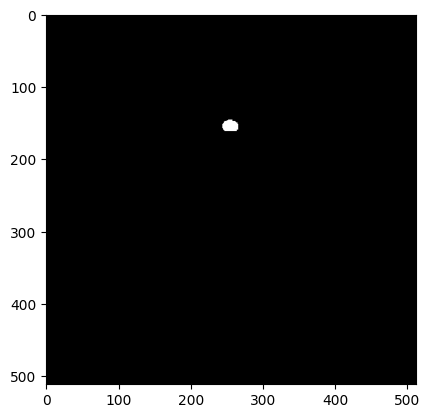

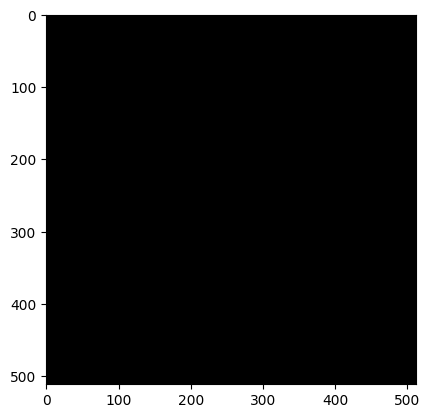

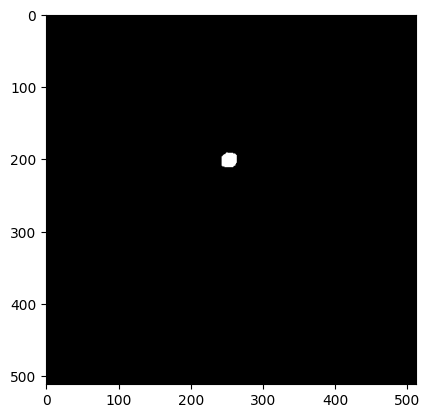

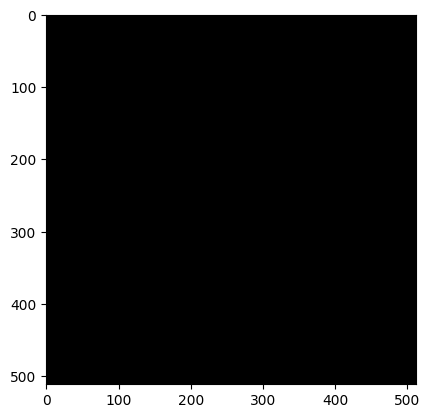

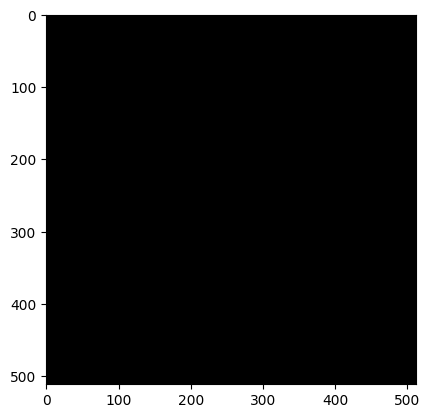

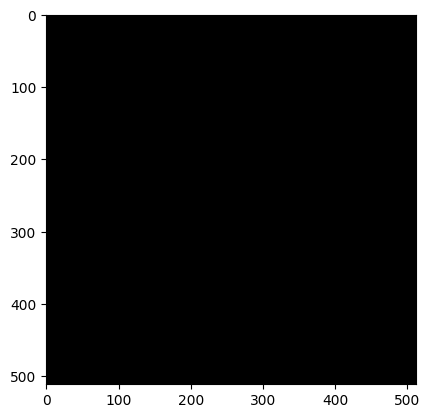

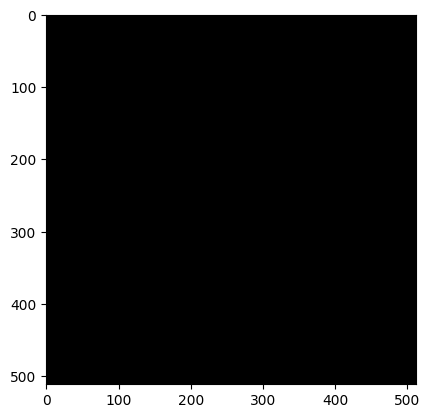

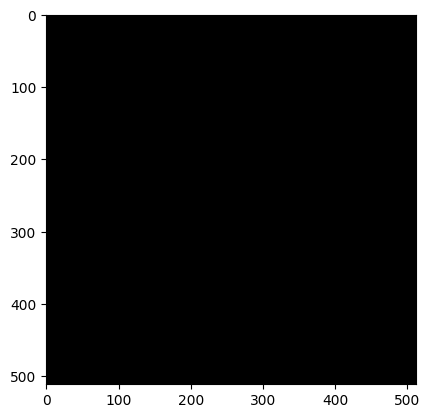

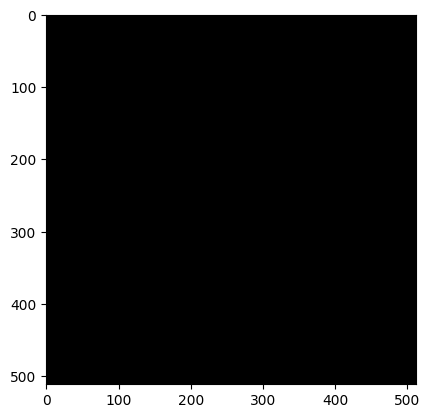

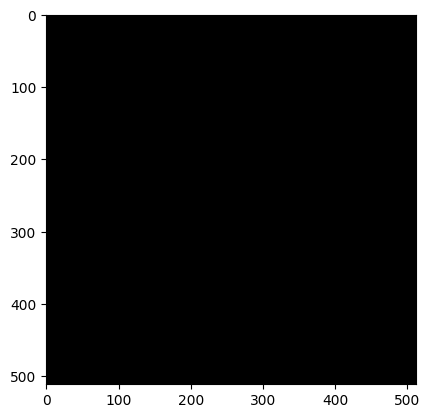

In [7]:
masks = list()
for idx in range(len(tumor_preds)):
    label_img = np.zeros((512,512), dtype='uint8')
    label_img = cv2.drawContours(label_img, tumor_preds[idx], -1, 255, thickness=cv2.FILLED)
    plt.imshow(label_img, cmap="gray")
    plt.show()
    masks.append(label_img)

In [8]:
# Convert slice locations to float and sort along with masks
sorted_indices = np.argsort(slice_locations)
slice_locations.sort()
masks_sorted = [masks[i] for i in sorted_indices]

In [9]:
# Pixel spacing and slice thickness (in mm)
px_spacing = 0.6328125
py_spacing = 0.6328125
slice_thickness = 5.0

In [10]:
# Create 3D grid for interpolation
z = np.array(slice_locations)
y = np.arange(0, masks[0].shape[0] * px_spacing, px_spacing)
x = np.arange(0, masks[0].shape[1] * px_spacing, px_spacing)

In [11]:
# Convert sorted masks to binary and stack along the z-axis
masks_bin = np.array([(mask > 0).astype(int) for mask in masks_sorted])

In [12]:
# Create 3D grid for the masks
z_mask = np.arange(z.min(), z.max() + slice_thickness, slice_thickness)
x_mask, y_mask, z_mask = np.meshgrid(x, y, z_mask, indexing='ij')

In [13]:
# Create the interpolator function
interpolator = interpolate.RegularGridInterpolator((x, y, z), np.moveaxis(masks_bin, 0, -1), method='nearest', bounds_error=False, fill_value=0)

# Interpolate to fill missing slices
vol = interpolator((x_mask, y_mask, z_mask))

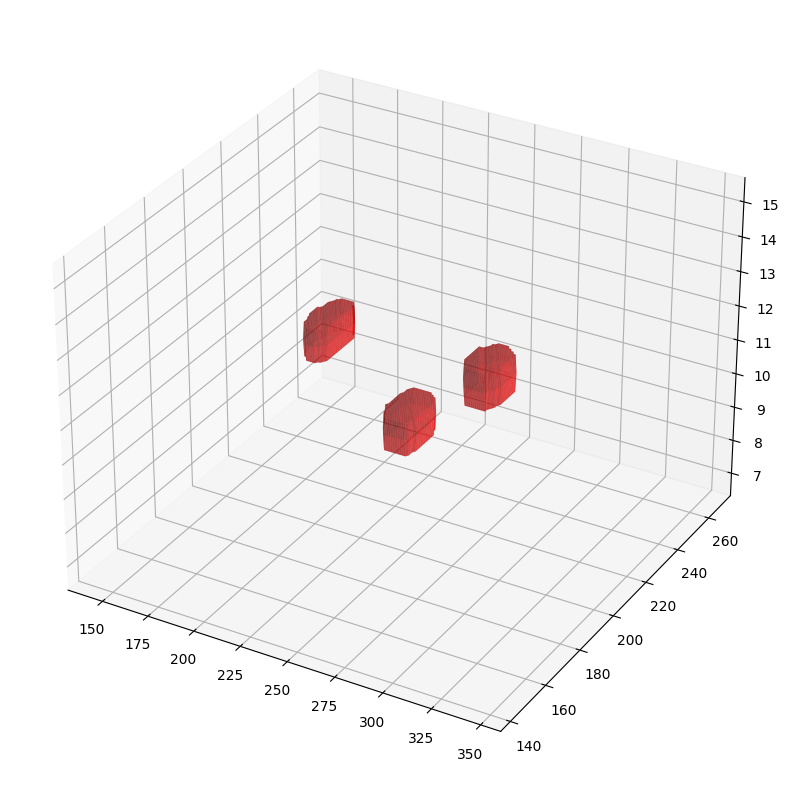

In [14]:
# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, _, _ = measure.marching_cubes(vol, level=0.5)

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2],
                linewidth=0.2, antialiased=True, color='red', alpha=0.5)

plt.show()

In [15]:
# Calculate the volume in cubic millimeters
pixel_volume = px_spacing ** 2 * slice_thickness
total_volume = np.sum(vol) * pixel_volume

total_volume

1856.0934448242188